## Step 1: Data Acquisition

In [1]:
import json
import requests

In [2]:
LEGACY_PAGECOUNTS_API = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access_site}/{granularity}/{start}/{end}"

def legacy_pagecounts_api_call(parameters):
    """
    Accepts parameters for the Legacy Pagecounts API, calls the API, and writes the results
    to a JSON file with a deterministic name based on the API query. Returns the name of the
    JSON file that was written to.
    """
    response = requests.get(LEGACY_PAGECOUNTS_API.format(**parameters))
    outfile_name = "pagecounts_{access_site}_{start_month}-{end_month}.json".format(
        access_site=parameters["access_site"],
        start_month=parameters["start"][:6],  # extract the year and month from the full date
        end_month=parameters["end"][:6],
    )
    with open(outfile_name, "w") as outfile:
        json.dump(response.json(), outfile)
    return outfile_name

In [3]:
PAGEVIEWS_API = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}"

def pageviews_api_call(parameters):
    """
    Accepts parameters for the Pageviews API, calls the API, and writes the results to a JSON
    file with a deterministic name based on the API query. Returns the name of the JSON file
    that was written to.
    """
    response = requests.get(PAGEVIEWS_API.format(**parameters))
    outfile_name = "pageviews_{access}_{start_month}-{end_month}.json".format(
        access=parameters["access"],
        start_month=parameters["start"][:6],
        end_month=parameters["end"][:6],
    )
    with open(outfile_name, "w") as outfile:
        json.dump(response.json(), outfile)
    return outfile_name

In the data acquisition step, we will use both the older [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) and the newer [Pageviews API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews). The Legacy Pagecounts API will be used for desktop/mobile view counts for the months between December 2007 and July 2016, inclusively. The Pageviews API will be used for desktop/mobile web/mobile app view counts for the months between July 2015 and September 2018, inclusively. The Pageviews API allows us to filter out presumably non-user requested page views (crawlers, spiders, bots, etc.), which we will take advantage of. The same filtering can not be done through the older Legacy Pagecounts API. For both APIs, when querying with a monthly granularity, the month range specified by the start month and end month is exclusive on the end month.

Each single API call will write its results to a JSON file, which together, form the output of the data acquisition step/input to the data processing step.

In [4]:
PAGECOUNTS_ALL_MONTHLY_DESKTOP_ENGLISH_WIKIPEDIA_VIEWS_PARAMS = {
    "project": "en.wikipedia.org",
    "access_site": "desktop-site",
    "granularity": "monthly",
    "start": "2007120100",
    "end": "2016080100",
}
PAGECOUNTS_ALL_MONTHLY_MOBILE_ENGLISH_WIKIPEDIA_VIEWS_PARAMS = {
    "project": "en.wikipedia.org",
    "access_site": "mobile-site",
    "granularity": "monthly",
    "start": "2007120100",
    "end": "2016080100",
}
PAGEVIEWS_ALL_MONTHLY_USER_DESKTOP_ENGLISH_WIKIPEDIA_VIEWS_PARAMS = {
    "project": "en.wikipedia.org",
    "access": "desktop",
    "agent": "user",
    "granularity": "monthly",
    "start": "2015070100",
    "end": "2018100100",
}
PAGEVIEWS_ALL_MONTHLY_USER_MOBILE_WEB_ENGLISH_WIKIPEDIA_VIEWS_PARAMS = {
    "project": "en.wikipedia.org",
    "access": "mobile-web",
    "agent": "user",
    "granularity": "monthly",
    "start": "2015070100",
    "end": "2018100100",
}
PAGEVIEWS_ALL_MONTHLY_USER_MOBILE_APP_ENGLISH_WIKIPEDIA_VIEWS_PARAMS = {
    "project": "en.wikipedia.org",
    "access": "mobile-app",
    "agent": "user",
    "granularity": "monthly",
    "start": "2015070100",
    "end": "2018100100",
}

# Executes the 5 relevant API calls and stores the created JSON file names for the next step
JSON_FILENAMES = [
    legacy_pagecounts_api_call(PAGECOUNTS_ALL_MONTHLY_DESKTOP_ENGLISH_WIKIPEDIA_VIEWS_PARAMS),
    legacy_pagecounts_api_call(PAGECOUNTS_ALL_MONTHLY_MOBILE_ENGLISH_WIKIPEDIA_VIEWS_PARAMS),
    pageviews_api_call(PAGEVIEWS_ALL_MONTHLY_USER_DESKTOP_ENGLISH_WIKIPEDIA_VIEWS_PARAMS),
    pageviews_api_call(PAGEVIEWS_ALL_MONTHLY_USER_MOBILE_WEB_ENGLISH_WIKIPEDIA_VIEWS_PARAMS),
    pageviews_api_call(PAGEVIEWS_ALL_MONTHLY_USER_MOBILE_APP_ENGLISH_WIKIPEDIA_VIEWS_PARAMS),
]

## Step 2: Data Processing

In [5]:
import csv

In [6]:
def populate_views_data_structure(json_filenames):
    """
    Accepts all JSON file names containing monthly view count data. Returns a layered
    dictionary, with the months as the primary keys, the API names as the secondary keys, the
    access methods as the tertiary keys, and finally the view counts as the values. This acts
    as an intermediate data structure between the multiple JSON files and the single CSV file.
    """
    views_data_structure = {}
    for json_filename in json_filenames:
        api_name, full_access_method, _ = json_filename.split("_")
        # the field name that stores the number of page views differs between both APIs
        views_key = "count" if api_name == "pagecounts" else "views"
        # classifies an access method as either "desktop" or "mobile"
        access_method = full_access_method.split("-")[0]
        with open(json_filename, "r") as json_file:
            json_data = json.load(json_file)
            for monthly_view_object in json_data["items"]:
                year_month = monthly_view_object["timestamp"][:6]
                if year_month not in views_data_structure.keys():
                    # defaults all page views to zero
                    views_data_structure[year_month] = {
                        "pagecounts": {
                            "desktop": 0,
                            "mobile": 0,
                        },
                        "pageviews": {
                            "desktop": 0,
                            "mobile": 0,
                        },
                    }
                view_count = monthly_view_object[views_key]
                views_data_structure[year_month][api_name][access_method] += view_count
    return views_data_structure

In [7]:
CSV_HEADERS = [
    "year",
    "month",
    "pagecount_all_views",
    "pagecount_desktop_views",
    "pagecount_mobile_views",
    "pageview_all_views",
    "pageview_desktop_views",
    "pageview_mobile_views",
]

def convert_views_data_to_csv(views_data_structure, filename_prefix):
    """
    Accepts a view count layered dictionary data structure and a prefix for the file to be
    written to. Transforms/writes the view count data structure into a CSV file, given a static
    set of headers. Returns the deterministic file name for the CSV file, given the prefix and
    the date range of the view count data.
    """
    date_range = sorted(views_data_structure.keys())
    # uses the first and last months of the view count data to create the CSV file name
    filename = "{filename_prefix}_{start_month}-{end_month}.csv".format(
        filename_prefix=filename_prefix,
        start_month=date_range[0],
        end_month=date_range[-1],
    )
    with open(filename, "w") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(CSV_HEADERS)
        for year_month in date_range:
            views_object = views_data_structure[year_month]
            year, month = year_month[:4], year_month[4:]
            pagecount_desktop_views = views_object["pagecounts"]["desktop"]
            pagecount_mobile_views = views_object["pagecounts"]["mobile"]
            pagecount_all_views = pagecount_desktop_views + pagecount_mobile_views
            pageviews_desktop_views = views_object["pageviews"]["desktop"]
            pageviews_mobile_views = views_object["pageviews"]["mobile"]
            pageviews_all_views = pageviews_desktop_views + pageviews_mobile_views
            csv_writer.writerow([
                year,
                month,
                pagecount_all_views,
                pagecount_desktop_views,
                pagecount_mobile_views,
                pageviews_all_views,
                pageviews_desktop_views,
                pageviews_mobile_views
            ])
    return filename

In the data processing step, we will transform the multiple JSON files containing results from the multiple API calls executed during the data acquisition step into a single CSV file. For each month (ranging from December 2007 to September 2018) and for each API used (Legacy Pagecounts and Pageviews), we will save/write the number of page views for the desktop site and the mobile site. The newer Pageviews API keeps track of both mobile _web_ views and mobile _app_ views. We will add these view counts together to form the number of mobile site views reported by the Pageviews API for each month.

The CSV file will store these values:

|**Column**             |**Value**|
|-----------------------|---------|
|year                   |YYYY     |
|month                  |MM       |
|pagecount_all_views    |num_views|
|pagecount_desktop_views|num_views|
|pagecount_mobile_views |num_views|
|pageview_all_views     |num_views|
|pageview_desktop_views |num_views|
|pageview_mobile_views  |num_views|

and will be the sole output of the data processing step/input to the data analysis step.

In [8]:
views_data_structure = populate_views_data_structure(JSON_FILENAMES)
CSV_FILENAME = convert_views_data_to_csv(views_data_structure, "en-wikipedia_traffic")

## Step 3: Data Analysis

In [9]:
import datetime
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import pandas

In [10]:
# scale to scale down the view counts for the time series plot
SCALE = 1000000

def scale_and_remove_zero_values(column):
    """
    Accepts a column of view count values and returns that column with the view counts scaled
    down and zero values removed, so they will be ignored by the time series plot.
    """
    return [views/SCALE if views > 0 else None for views in column]

def plot_traffic(csv_file):
    """
    Accepts the CSV file of view count data and plots the data in a time series plot.
    """
    views_df = pandas.read_csv(csv_file)
    year_months = zip(views_df["year"], views_df["month"])
    # converts string formatted months into python datetime objects, to take advantage of
    # matplotlib's "plot_date" method
    date_objects = [datetime.date(year, month, 1) for year, month in year_months]
    figure = plt.figure(figsize=(16, 8))
    plt.plot_date(
        x=date_objects,
        y=scale_and_remove_zero_values(views_df["pagecount_desktop_views"]),
        fmt="--",  # results from the Legacy Pagecounts API are displayed as dashed lines
        color="green",  # desktop site view counts are represented by the color green
        label="desktop, Legacy Pagecounts"
    )
    plt.plot_date(
        x=date_objects,
        y=scale_and_remove_zero_values(views_df["pageview_desktop_views"]),
        fmt="-",  # results from the Pageviews API are displayed as solid lines
        color="green",
        label="desktop, Pageviews"
    )
    plt.plot_date(
        x=date_objects,
        y=scale_and_remove_zero_values(views_df["pagecount_mobile_views"]),
        fmt="--",
        color="blue",  # mobile site view counts are represented by the color blue
        label="mobile, Legacy Pagecounts"
    )
    plt.plot_date(
        x=date_objects,
        y=scale_and_remove_zero_values(views_df["pageview_mobile_views"]),
        fmt="-",
        color="blue",
        label="mobile, Pageviews"
    )
    plt.plot_date(
        x=date_objects,
        y=scale_and_remove_zero_values(views_df["pagecount_all_views"]),
        fmt="--",
        color="black",  # total view counts are represented by the color black
        label="total, Legacy Pagecounts"
    )
    plt.plot_date(
        x=date_objects,
        y=scale_and_remove_zero_values(views_df["pageview_all_views"]),
        fmt="-",
        color="black",
        label="total, Pageviews"
    )
    # assure ticks are shown along the x-axis for every year (ticks are displayed on the month
    # of January)
    plt.xticks([date2num(date_obj) for date_obj in date_objects if date_obj.month == 1])
    # assure the y-axis starts at 0 view counts so view count ratios can be visualized
    plt.ylim(bottom=0)
    # add grid lines to the plot to help the consumer estimate values of points
    plt.grid()
    plt.title("Monthly Page Views on English Wikipedia by Access Method")
    plt.ylabel("Views (Millions)")
    plt.legend()
    # save the figure
    plt.savefig(fname=CSV_FILENAME.split(".")[0])

In the data analysis step, view counts from the CSV file created in the data processing step will be visualized using a time series plot. The plot will also be saved as a `.png` file, which will be the output of the data analysis step.

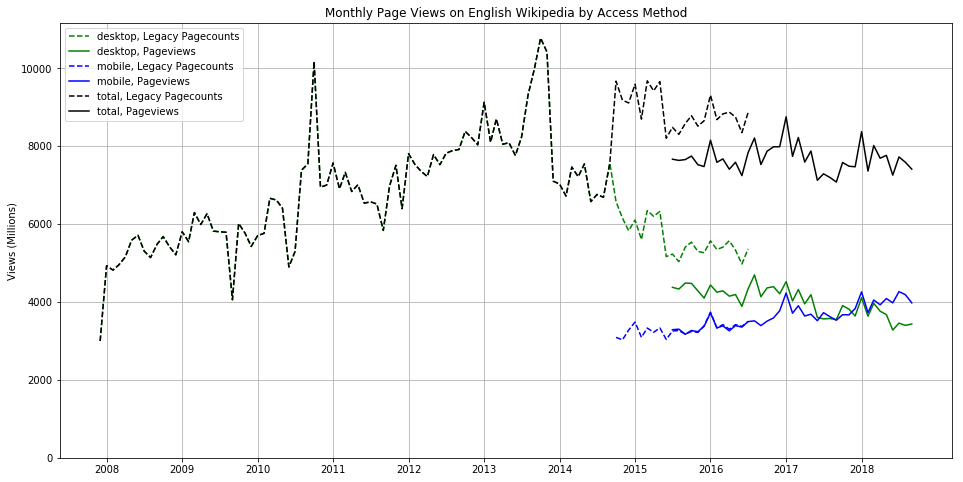

In [11]:
plot_traffic(CSV_FILENAME)